In [1]:
import pandas as pd, numpy as np
from pathlib import Path
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import shap, matplotlib.pyplot as plt, seaborn as sns
import gseapy as gp
import warnings
warnings.filterwarnings("ignore")

DATA = Path("../data").resolve()
RESULTS = Path("../results").resolve()
(RESULTS / "figures").mkdir(parents=True, exist_ok=True)
(RESULTS / "models").mkdir(parents=True, exist_ok=True)

np.random.seed(42)


C:\Users\Admin\anaconda3\envs\drugresp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ---- Synthetic data generator ----
# This block creates a mock dataset (300 samples × 1000 genes)
# and a simulated IC50 response for one demo drug.

n_samples, n_genes = 300, 1000
genes = [f"GENE_{i}" for i in range(n_genes)]

# Random normally distributed expression matrix
expression = pd.DataFrame(
    np.random.randn(n_samples, n_genes),
    index=[f"CL_{i}" for i in range(n_samples)],
    columns=genes
)

# A few genes actually influence the response signal
signal_genes = ["GENE_5", "GENE_25", "GENE_77", "GENE_301"]
true_signal = expression[signal_genes].sum(axis=1) + 0.5 * np.random.randn(n_samples)

# Normalize to 0–1 scale to mimic IC50/AUC
ic50 = (true_signal - true_signal.min()) / (true_signal.max() - true_signal.min())

# Combine into a response DataFrame
response = pd.DataFrame({
    "cell_line": expression.index,
    "drug": "DemoDrug",
    "ic50": ic50
})

# Quick sanity check
print("Expression shape:", expression.shape)
print("Response shape:", response.shape)
display(expression.head(3))
display(response.head(3))


Expression shape: (300, 1000)
Response shape: (300, 3)


,GENE_0,GENE_1,GENE_2,GENE_3,GENE_4,GENE_5,GENE_6,GENE_7,GENE_8,GENE_9,...,GENE_990,GENE_991,GENE_992,GENE_993,GENE_994,GENE_995,GENE_996,GENE_997,GENE_998,GENE_999
CL_0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,...,0.208383,-2.041735,-0.247177,-0.681984,-1.001620,-0.281100,1.797687,0.640843,-0.571179,0.572583
CL_1,1.399355,0.924634,0.059630,-0.646937,0.698223,0.393485,0.895193,0.635172,1.049553,-0.535235,...,0.800410,0.754291,1.188913,0.708304,0.351448,1.070150,-0.026521,-0.881875,-0.163067,-0.744903
CL_2,-0.675178,-0.144519,-0.792420,-0.307962,-1.893615,0.213294,0.001205,-0.817089,0.659246,0.937570,...,1.516394,0.602118,0.072037,-0.212209,-0.951918,0.077481,0.257753,-1.241761,0.334176,-0.155259


,cell_line,drug,ic50
CL_0,CL_0,DemoDrug,0.408729
CL_1,CL_1,DemoDrug,0.709123
CL_2,CL_2,DemoDrug,0.608238


In [3]:
# ---- Align expression and response tables for one drug ----

# Select the current drug (in real data you can specify, e.g., "Trametinib")
drug_name = response["drug"].iloc[0]  
resp_d = response[response["drug"] == drug_name].copy()

# Align sample IDs between expression and response tables
common = expression.index.intersection(resp_d["cell_line"])

X = expression.loc[common].copy()
y = resp_d.set_index("cell_line").loc[common, "ic50"].astype(float)

print(f"Drug selected: {drug_name}")
print("Feature matrix (X):", X.shape)
print("Target vector (y):", y.shape)
display(X.head(3))
display(y.head(3))


Drug selected: DemoDrug
Feature matrix (X): (300, 1000)
Target vector (y): (300,)


,GENE_0,GENE_1,GENE_2,GENE_3,GENE_4,GENE_5,GENE_6,GENE_7,GENE_8,GENE_9,...,GENE_990,GENE_991,GENE_992,GENE_993,GENE_994,GENE_995,GENE_996,GENE_997,GENE_998,GENE_999
CL_0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,...,0.208383,-2.041735,-0.247177,-0.681984,-1.001620,-0.281100,1.797687,0.640843,-0.571179,0.572583
CL_1,1.399355,0.924634,0.059630,-0.646937,0.698223,0.393485,0.895193,0.635172,1.049553,-0.535235,...,0.800410,0.754291,1.188913,0.708304,0.351448,1.070150,-0.026521,-0.881875,-0.163067,-0.744903
CL_2,-0.675178,-0.144519,-0.792420,-0.307962,-1.893615,0.213294,0.001205,-0.817089,0.659246,0.937570,...,1.516394,0.602118,0.072037,-0.212209,-0.951918,0.077481,0.257753,-1.241761,0.334176,-0.155259


CL_0    0.408729
CL_1    0.709123
CL_2    0.608238
Name: ic50, dtype: float64

In [4]:
# ---- Basic feature filtering ----
# Remove near-constant (low-variance) genes that don't help prediction.

var = X.var(axis=0)
X = X.loc[:, var > var.quantile(0.1)]  # Keep top 90% most variable genes

print("Features after variance filter:", X.shape[1])


Features after variance filter: 900


In [6]:
# ---- Train/test split + baseline models ----

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import spearmanr

# Split into training (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest model
rf = Pipeline([
    ("model", RandomForestRegressor(
        n_estimators=500, random_state=42, n_jobs=-1
    ))
])

# XGBoost model
xgb = Pipeline([
    ("model", XGBRegressor(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    ))
])

# Evaluation helper
def evaluate(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred)
    rmse = mean_squared_error(y_test, pred) ** 0.5
    spearman = spearmanr(y_test, pred).correlation
    print(f"{name:12s} | R² = {r2:.3f} | RMSE = {rmse:.3f} | Spearman = {spearman:.3f}")
    return pred, model

# Train and test both models
pred_rf,  model_rf  = evaluate("RandomForest", rf)
pred_xgb, pipeline_xgb = evaluate("XGBoost", xgb)

# Keep a handle to the fitted XGBoost model for later plots
model_xgb = pipeline_xgb.named_steps["model"]


RandomForest | R² = 0.545 | RMSE = 0.126 | Spearman = 0.797
XGBoost      | R² = 0.549 | RMSE = 0.126 | Spearman = 0.808


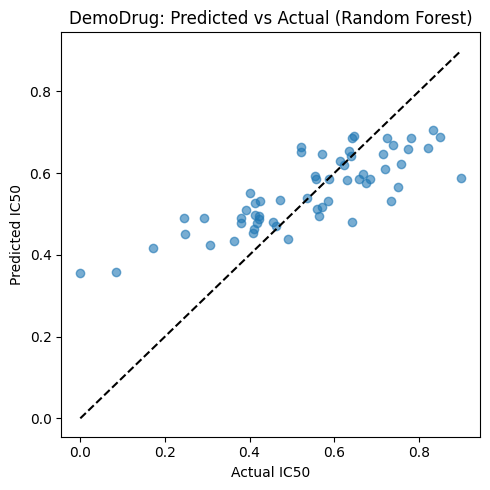

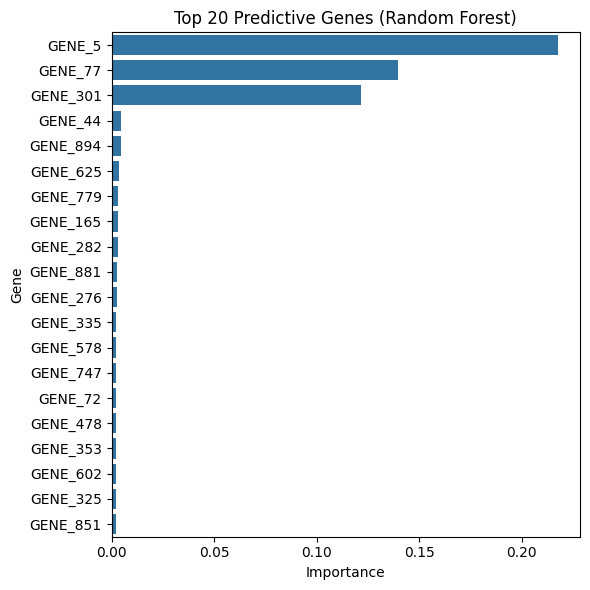

In [7]:
# ---- Visualization: Predicted vs Actual + Top Genes ----

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

RESULTS = Path("../results").resolve()
(RESULTS / "figures").mkdir(parents=True, exist_ok=True)

# --- Predicted vs Actual (Random Forest) ---
plt.figure(figsize=(5,5))
plt.scatter(y_test, pred_rf, alpha=0.6)
plt.xlabel("Actual IC50")
plt.ylabel("Predicted IC50")
plt.title("DemoDrug: Predicted vs Actual (Random Forest)")
lims = [min(y_test.min(), pred_rf.min()), max(y_test.max(), pred_rf.max())]
plt.plot(lims, lims, 'k--')
plt.tight_layout()
plt.savefig(RESULTS / "figures" / "pred_vs_actual_rf.png", dpi=300)
plt.show()

# --- Feature Importance (Random Forest) ---
model_rf = rf.named_steps["model"]
importances = model_rf.feature_importances_
top_idx = np.argsort(importances)[-20:][::-1]
top_genes = X.columns[top_idx]

plt.figure(figsize=(6,6))
sns.barplot(x=importances[top_idx], y=top_genes)
plt.xlabel("Importance")
plt.ylabel("Gene")
plt.title("Top 20 Predictive Genes (Random Forest)")
plt.tight_layout()
plt.savefig(RESULTS / "figures" / "feature_importance_rf.png", dpi=300)
plt.show()


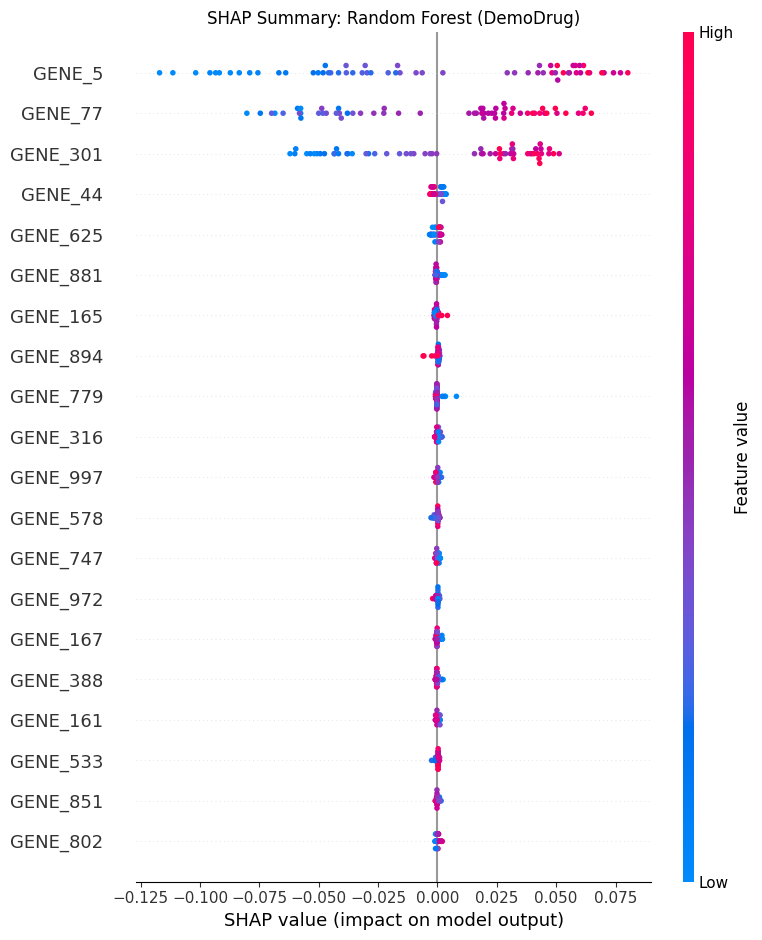

In [8]:
# ---- SHAP Explainability ----
import shap
import matplotlib.pyplot as plt

# Build a SHAP explainer for the trained Random Forest model
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_test)

# Summary plot (global importance)
plt.title("SHAP Summary: Random Forest (DemoDrug)")
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig(RESULTS / "figures" / "shap_summary_rf.png", dpi=300, bbox_inches="tight")
plt.show()
